In [1]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

In [4]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c

In [7]:
dir = '/home/user/Desktop/Datos/'
#dir = '/Users/antoniomendez/Desktop/Tesis/Datos/datos_limpios/'

In [87]:
def leer_matriz(nombre_archivo):
    matriz = []
    with open(nombre_archivo, 'r') as archivo:
        archivo.readline()
        archivo.readline()
        for linea in archivo:
            fila = [float(valor) for valor in linea.strip().split()]
            matriz.append(fila)
    return matriz

def encontrar_estacion(est, matriz):
    for i in range(len(matriz)):
        if matriz[i][0] == est:
            # latitud, longitud
            return matriz[i][1], matriz[i][2]
    return None, None

def count_trips_mibici(data_user, threshold = 5, complement = False):
    viajes_user = data_user.groupby([data_user[['Origen_Id', 'Destino_Id']].min(axis=1), data_user[['Origen_Id', 'Destino_Id']].max(axis=1)]).size().reset_index(name='counts')
    viajes_user.columns = ['Est_A', 'Est_B', 'counts']
    if not complement:
        viajes_user = viajes_user[viajes_user['counts'] >= threshold]
    else:
        viajes_user = viajes_user[viajes_user['counts'] < threshold]
    if viajes_user.empty:
        return None
    total = viajes_user['counts'].sum()
    viajes_user['prob'] = viajes_user['counts']/total
    viajes_user = viajes_user.sort_values(by = 'prob', ascending = False).reset_index(drop=True)
    return viajes_user

In [9]:
data_2019_mibici = pd.read_csv(dir + 'mibici/mibici_2019.csv')
est_2019_mibici = leer_matriz(dir + 'Adj_mibici/matrices_estaciones/est_2019.txt')

In [10]:
data_2019_mibici.head()

,Viaje_Id,Usuario_Id,Genero,Año_de_nacimiento,Inicio_del_viaje,Fin_del_viaje,Origen_Id,Destino_Id,Tiempo_viaje
0,8901295,341162,M,1992.0,2019-01-01 00:00:00,2019-01-01 00:16:09,50,54,16.150000
1,8901296,413443,M,1985.0,2019-01-01 06:01:05,2019-01-01 06:16:27,38,194,15.366667
2,8901297,444232,M,1995.0,2019-01-01 06:01:19,2019-01-01 06:09:55,86,18,8.600000
3,8901298,437533,M,1998.0,2019-01-01 06:01:25,2019-01-01 06:02:04,86,86,0.650000
4,8901299,430224,M,1992.0,2019-01-01 06:01:57,2019-01-01 06:05:01,27,52,3.066667


In [11]:
data = data_2019_mibici[data_2019_mibici['Inicio_del_viaje'].str.contains('2019-01-01')]

In [90]:
counter = count_trips_mibici(data, threshold = 1)
counter.head()

,Est_A,Est_B,counts,prob
0,229,229,22,0.008346
1,35,35,15,0.005690
2,157,296,9,0.003414
3,25,25,8,0.003035
4,63,85,8,0.003035


In [91]:
number_of_trips = len(counter)
number_of_trips

1716

In [92]:
flows = dict()
for i in range(number_of_trips):
    start = counter.iloc[i]['Est_A']
    end = counter.iloc[i]['Est_B']
    start_lat, start_lon = encontrar_estacion(start, est_2019_mibici)
    end_lat, end_lon = encontrar_estacion(end, est_2019_mibici)
    flows[f'F{i}'] = {'origin': (start_lat, start_lon), 'destination': (end_lat, end_lon)}


In [123]:
def get_edges(flows, threshold):
    edges = []
    for flow1, data1 in flows.items():
        for flow2, data2 in flows.items():
            if flow1 == flow2:
                continue
            origin1, destination1 = data1['origin'], data1['destination']
            origin2, destination2 = data2['origin'], data2['destination']
            distance1 = haversine(origin1[0], origin1[1], origin2[0], origin2[1])
            distance2 = haversine(destination1[0], destination1[1], destination2[0], destination2[1])
            if distance1 < threshold and distance2 < threshold:
                edges.append((flow1, flow2))
    return edges

In [132]:
# Parámetro de umbral de distancia
threshold = 0.5 # km

In [133]:
edges = get_edges(flows, threshold)

In [134]:
# para construir el grafo

G = nx.Graph()
G.add_nodes_from(flows.keys())
G.add_edges_from(edges)
A = nx.adjacency_matrix(G)

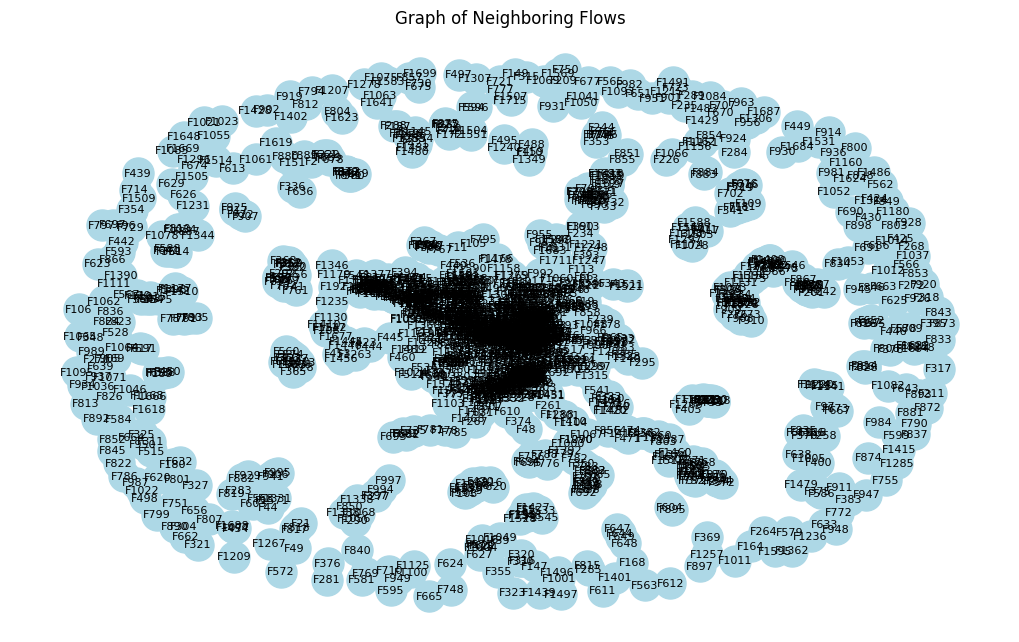

In [135]:
# para ver el grafo
pos = nx.spring_layout(G)

# Dibujar el grafo
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=8)
plt.title("Graph of Neighboring Flows")
plt.show()

In [ ]:
# obtención de las comunidades de la red
communities = list(nx.community.greedy_modularity_communities(G))
print('Total number of communities:', len(communities))
print

Total number of communities: 327


In [140]:
for i, community in enumerate(communities):
    print(f"Community {i + 1}, len: {len(list(community))}: {list(community)}")

Community 1, len: 351: ['F524', 'F9', 'F1186', 'F1258', 'F1217', 'F554', 'F1488', 'F298', 'F245', 'F37', 'F1188', 'F1083', 'F420', 'F1153', 'F468', 'F1211', 'F1134', 'F1357', 'F1474', 'F1076', 'F1438', 'F1201', 'F233', 'F1373', 'F440', 'F241', 'F737', 'F1574', 'F1612', 'F75', 'F1342', 'F1189', 'F243', 'F122', 'F175', 'F557', 'F1202', 'F309', 'F1295', 'F1108', 'F452', 'F1457', 'F1242', 'F1132', 'F133', 'F174', 'F1714', 'F80', 'F1513', 'F436', 'F1233', 'F712', 'F191', 'F1197', 'F1656', 'F29', 'F1423', 'F1363', 'F1703', 'F1341', 'F1484', 'F1518', 'F91', 'F1381', 'F1148', 'F392', 'F313', 'F1680', 'F114', 'F197', 'F184', 'F1443', 'F132', 'F886', 'F208', 'F223', 'F506', 'F1302', 'F1705', 'F38', 'F1079', 'F136', 'F1543', 'F1187', 'F144', 'F542', 'F198', 'F940', 'F73', 'F1339', 'F1213', 'F1673', 'F1487', 'F944', 'F467', 'F923', 'F1243', 'F1227', 'F388', 'F526', 'F1644', 'F78', 'F447', 'F1182', 'F254', 'F291', 'F1051', 'F1501', 'F549', 'F1105', 'F1663', 'F1658', 'F1121', 'F1671', 'F1655', 'F134

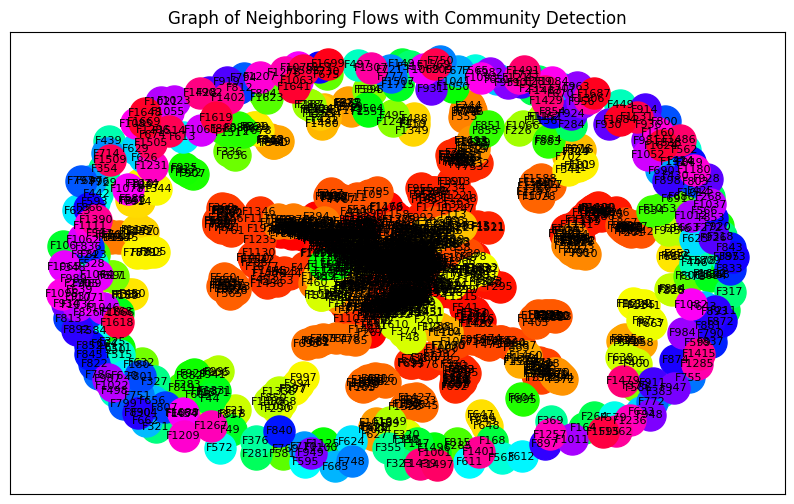

In [138]:
plt.figure(figsize=(10, 6))
n_colors = len(communities)
#colors = [plt.cm.Set3(i) for i in range(n_colors)]
colors = [plt.cm.hsv(i / n_colors) for i in range(n_colors)]

for idx, community in enumerate(communities):
    nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=[colors[idx]], node_size=500)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Graph of Neighboring Flows with Community Detection")
plt.show()

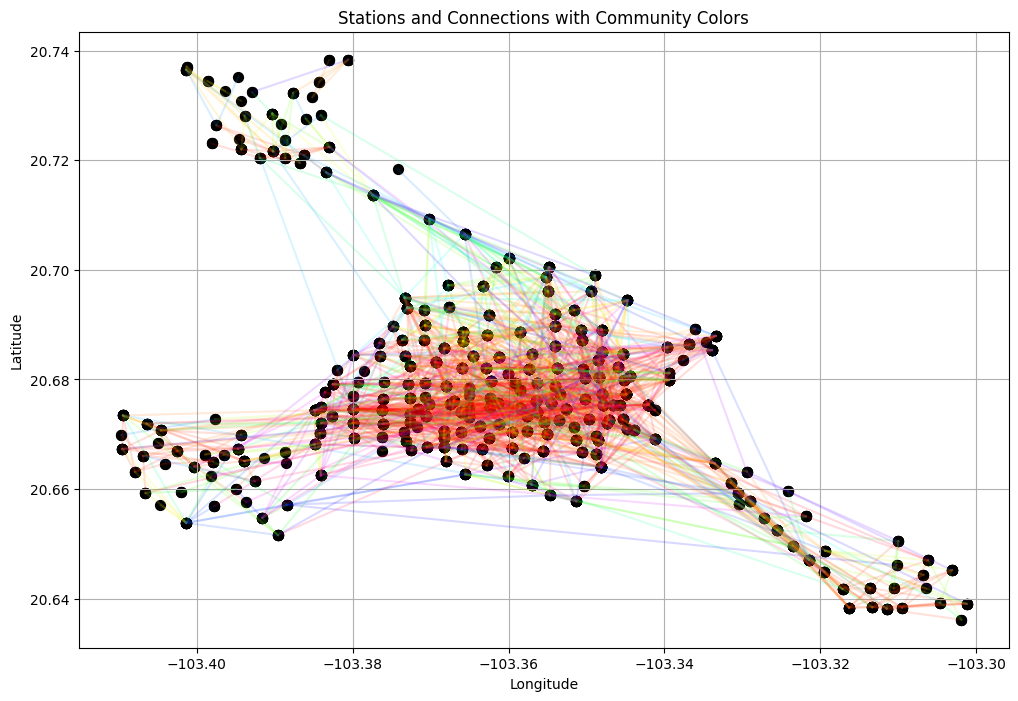

In [139]:
plt.figure(figsize=(12, 8))

# Dibujar las estaciones y las conexiones
for idx, community in enumerate(communities):
    community_color = colors[idx]
    for flow in community:
        origin = flows[flow]['origin']
        destination = flows[flow]['destination']
        plt.plot([origin[1], destination[1]], [origin[0], destination[0]], color=community_color, alpha=0.15)
        plt.scatter([origin[1], destination[1]], [origin[0], destination[0]], color='black', s=50)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.title('Stations and Connections with Community Colors')
plt.show()